# NL COVID 19 data exploration

- data from https://data.rivm.nl/covid-19/
- taken 2020-12-16

## Notes

- Given that daily reported numbers are in small quantities
(i.e. <100), changes represented in % changes
can be highly sensitive.
E.g. Changing from 1 to 5 is a 500% change.
- But % change is the only way to
compare change in qty across different slices
of data.
- So take those figures with a pinch of salt.
- That being said, we are looking for anomalies,
so a sufficiently large % change would signal
an abnormally large change.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import typing

plt.rcParams["figure.figsize"] = (20,15)
_FONTSIZE=20

# Initial data management
_DATADIR="_data"
_DATA_CUMUL="COVID-19_aantallen_gemeente_cumulatief-2020-12-16.csv"
cumul = pd.read_csv(os.path.join(_DATADIR, _DATA_CUMUL), delimiter=";")
cumul["Date_of_report"] = pd.to_datetime(cumul["Date_of_report"]) # set dtype of "Date_of_report" to pd.DatetimeTZDtype
cumul["Date_of_report"] = cumul["Date_of_report"].dt.normalize() # get date portion of datetime only
cumul.sort_values(by="Date_of_report",ascending=True,inplace=True)

 # Get only cases from Amsterdam:
cumul_ams = cumul[cumul["Municipality_name"].isin(["Amsterdam"])]

# compare day on day increments/deltas
def get_daily_delta(df: pd.DataFrame, col: str) -> typing.List[int]:
    """
    Returns list containing daily reported cases
    """
    daily_delta_column = []
    reported = df[col]
    for i in range(0,len(reported)):
        if i == 0:
            daily_delta_column.append(0)
            continue # skip this index
        daily_delta_column.append(
            reported.iloc[i]-reported.iloc[i-1]
        )

    return daily_delta_column

cumul_ams.insert(len(cumul_ams.columns), "Day",cumul_ams["Date_of_report"].dt.day_name()) # create new column for day of week
cumul_ams["Day"].astype("str")
cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number
cumul_ams.insert(len(cumul_ams.columns),"Daily_delta",get_daily_delta(cumul_ams, "Total_reported")) # add daily delta of total reported to df
cumul_ams.insert(len(cumul_ams.columns),"Deceased_delta",get_daily_delta(cumul_ams, "Deceased")) # add daily delta of total deceased to df
cumul_ams.insert(len(cumul_ams.columns),"Hospital_delta",get_daily_delta(cumul_ams, "Hospital_admission")) # add daily delta of total hospitalized to df

<ipython-input-1-d8a037701448>:41: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  cumul_ams.insert(len(cumul_ams.columns), "Week", cumul_ams["Date_of_report"].dt.week) # create new column for week number


### Get only the data we want from dataframe

In [2]:
# create working df with: date, cumulative day of week, week number, reports
cumuldf = cumul_ams[
    ["Date_of_report","Day","Week","Daily_delta", "Total_reported", "Deceased", "Deceased_delta", "Hospital_admission", "Hospital_delta"]
]
cumuldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 109 to 101768
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date_of_report      278 non-null    datetime64[ns]
 1   Day                 278 non-null    object        
 2   Week                278 non-null    int64         
 3   Daily_delta         278 non-null    int64         
 4   Total_reported      278 non-null    int64         
 5   Deceased            278 non-null    int64         
 6   Deceased_delta      278 non-null    int64         
 7   Hospital_admission  278 non-null    int64         
 8   Hospital_delta      278 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 21.7+ KB


### Data from last 10 days

In [3]:
cumuldf.tail(10)

,Date_of_report,Day,Week,Daily_delta,Total_reported,Deceased,Deceased_delta,Hospital_admission,Hospital_delta
98465,2020-12-06,Sunday,49,350,41555,430,2,1207,4
98832,2020-12-07,Monday,50,216,41771,430,0,1213,6
99199,2020-12-08,Tuesday,50,318,42089,436,6,1212,-1
99566,2020-12-09,Wednesday,50,416,42505,443,7,1215,3
99933,2020-12-10,Thursday,50,413,42918,445,2,1219,4
100300,2020-12-11,Friday,50,479,43397,447,2,1220,1
100667,2020-12-12,Saturday,50,391,43788,448,1,1231,11
101034,2020-12-13,Sunday,50,335,44123,449,1,1234,3
101401,2020-12-14,Monday,51,350,44473,449,0,1238,4
101768,2020-12-15,Tuesday,51,245,44718,451,2,1241,3


### Top 10 days (reported cases)

In [4]:
sorted_df = cumuldf[["Date_of_report","Week","Daily_delta","Total_reported","Hospital_delta"]].sort_values(by="Daily_delta",ascending=False)
sorted_df.head(10)

,Date_of_report,Week,Daily_delta,Total_reported,Hospital_delta
83051,2020-10-25,43,831,27273,8
81950,2020-10-22,43,813,25191,14
81583,2020-10-21,43,751,24378,7
82317,2020-10-23,43,745,25936,14
78647,2020-10-13,42,734,19163,16
80482,2020-10-18,42,726,22398,7
81216,2020-10-20,43,696,23627,3
80115,2020-10-17,42,687,21672,19
83785,2020-10-27,44,686,28485,6
79748,2020-10-16,42,682,20985,7


In [5]:
def get_week_start_end(df:pd.DataFrame, week_number:int)->typing.Tuple[str,str]:
    """
    Returns a tuple of (week_start, week_end),
    that are two strings:
    - week_start is the start date of a week (i.e. dd/mm on that monday)
    - week_end is the end date of a week (i.e. dd/mm on that sunday)
    """
    df_week = df["Week"]
    # this_week = df[df_week == df_week.max()-week_number]
    this_week = df[df_week == week_number]
    week_start = this_week.iloc[0]["Date_of_report"]
    week_start_d_m = f"{week_start.day}/{week_start.month}"
    week_end = this_week.iloc[-1]["Date_of_report"]
    week_end_d_m = f"{week_end.day}/{week_end.month}"
    return week_start_d_m, week_end_d_m


def plot_daily_delta_for_last_n_weeks(df:pd.DataFrame, n:int=3):
    """
    Plots n number of weeks
    worth of daily deltas in one line chart
    """
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.xlabel("Day of week", fontsize=_FONTSIZE)
    plt.yticks(np.arange(0, df["Daily_delta"].max(), step=5), fontsize=_FONTSIZE)
    plt.ylabel("Daily change", fontsize=_FONTSIZE)

    for week in range(0,n):
        this_week_number = df["Week"].max() - week
        this_week = df[df["Week"] == this_week_number]
        last_week = df[df["Week"] == this_week_number-1]

        x_range = ["(Sunday before)"]+this_week["Day"].to_list()
        including_last_sunday = [last_week["Daily_delta"].to_list()[-1]]+this_week["Daily_delta"].to_list()
        week_start_d_m, week_end_d_m = get_week_start_end(df,this_week_number)

        plt.plot(x_range,including_last_sunday,label=f"{week_start_d_m} – {week_end_d_m}")
    plt.legend(fontsize=_FONTSIZE)

### Plot daily reported cases, by week

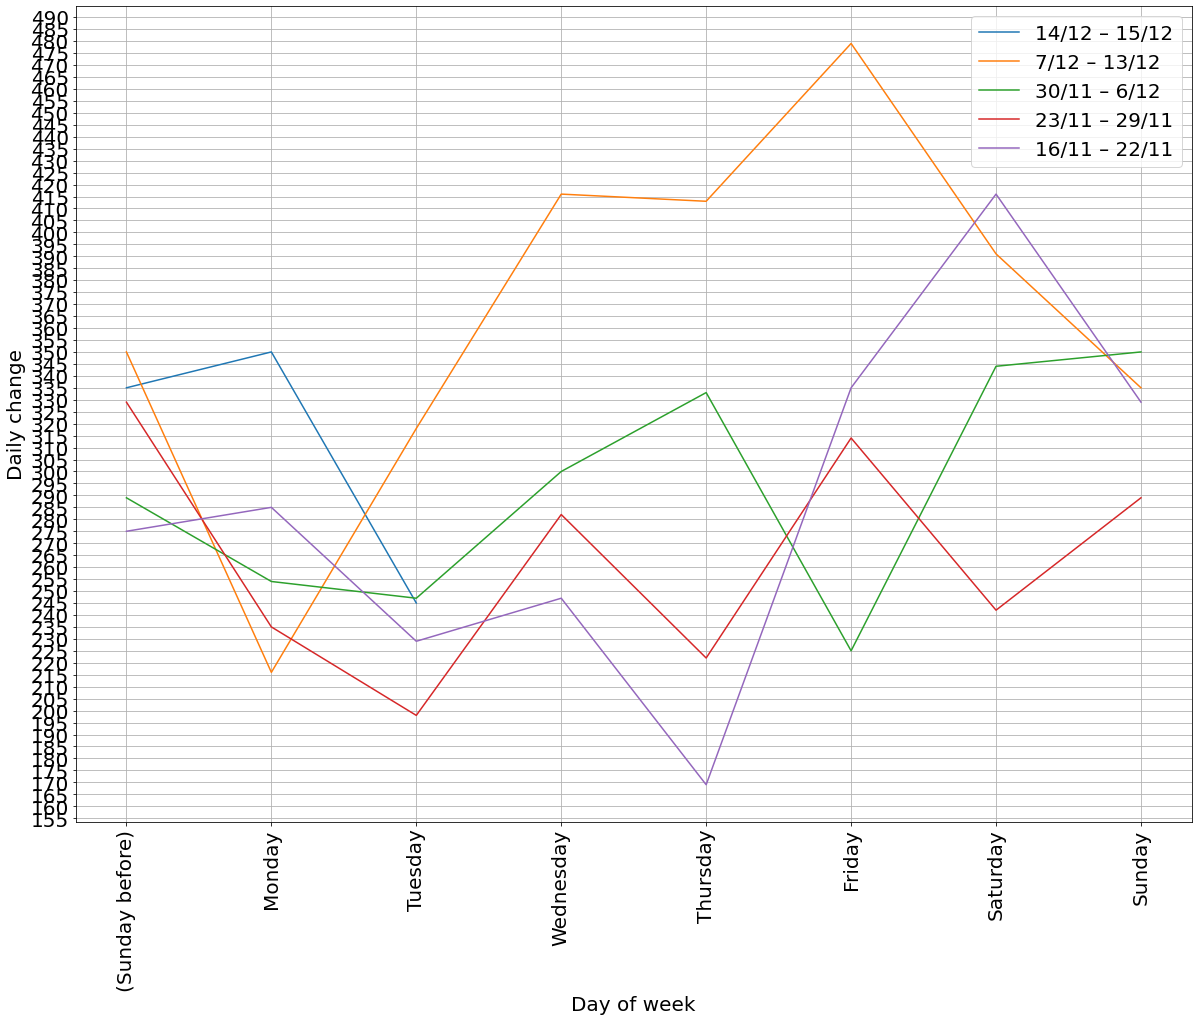

,Date_of_report,Week,Daily_delta,Total_reported
99566,2020-12-09,50,416,42505
99933,2020-12-10,50,413,42918
100300,2020-12-11,50,479,43397
100667,2020-12-12,50,391,43788
101034,2020-12-13,50,335,44123
101401,2020-12-14,51,350,44473
101768,2020-12-15,51,245,44718


In [6]:
plot_daily_delta_for_last_n_weeks(cumuldf, n=5)
plt.show()

cumuldf[["Date_of_report","Week","Daily_delta","Total_reported"]].tail(7)

In [7]:
def plot_weekly_delta_for_last_n_weeks(df:pd.DataFrame, n:int) -> typing.Dict[str,int]:
    """
    Returns a dict containing weekly delta for the last n weeks,
    like: {"Week n": int,"Week n-1": int, ...}
    """

    weekly_delta = {}
    for week in range(0,n):
        if df["Week"].max() < week:
            print(f"Week no. {df['Week'].max() - week} does not exist.")
            continue

        this_week_num = df["Week"].max() - week
        week_delta = df[df["Week"] == this_week_num]["Daily_delta"].sum()

        if this_week_num == 0:
            weekly_delta[f"Week {this_week_num}"] = 0
            continue
        else:
            weekly_delta[f"Week {this_week_num}"] = week_delta
            continue
    return weekly_delta



### Plot week-on-week reported cases

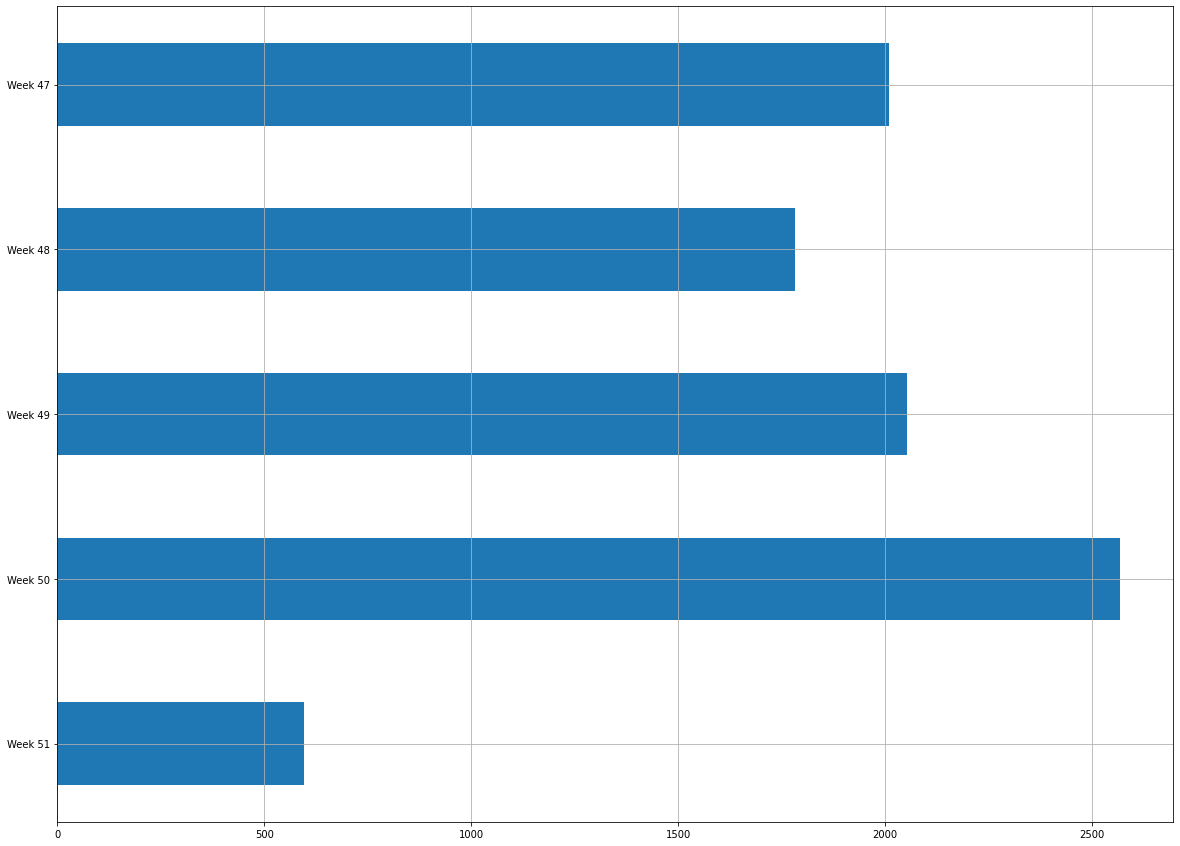

{'Week 47': 2010,
 'Week 48': 1782,
 'Week 49': 2053,
 'Week 50': 2568,
 'Week 51': 595}


In [8]:
weekly_delta = plot_weekly_delta_for_last_n_weeks(cumuldf, 5)
plt.grid(True)
plt.barh(
    list(weekly_delta.keys()),
    width=np.array(list(weekly_delta.values())),
    height=0.5
)
plt.show()
pprint(weekly_delta)

In [9]:
# Helper function to plot last n days cumulative reported cases

def plot_cumul_reported_last_n_days(df:pd.DataFrame,n:int=3, col:str="Total_reported") -> None:
    plot_this = df.tail(n)
    plt.grid(True)
    plt.xticks(rotation="vertical", fontsize=_FONTSIZE)
    plt.yticks(plot_this[col], fontsize=_FONTSIZE)
    plt.plot_date(
        plot_this["Date_of_report"].loc[-n:,],
        plot_this[col],
        xdate=True
    )
    plt.show()
    pprint(df[["Date_of_report", col]].tail(n))

### Cumulative reported cases for the last 30 days

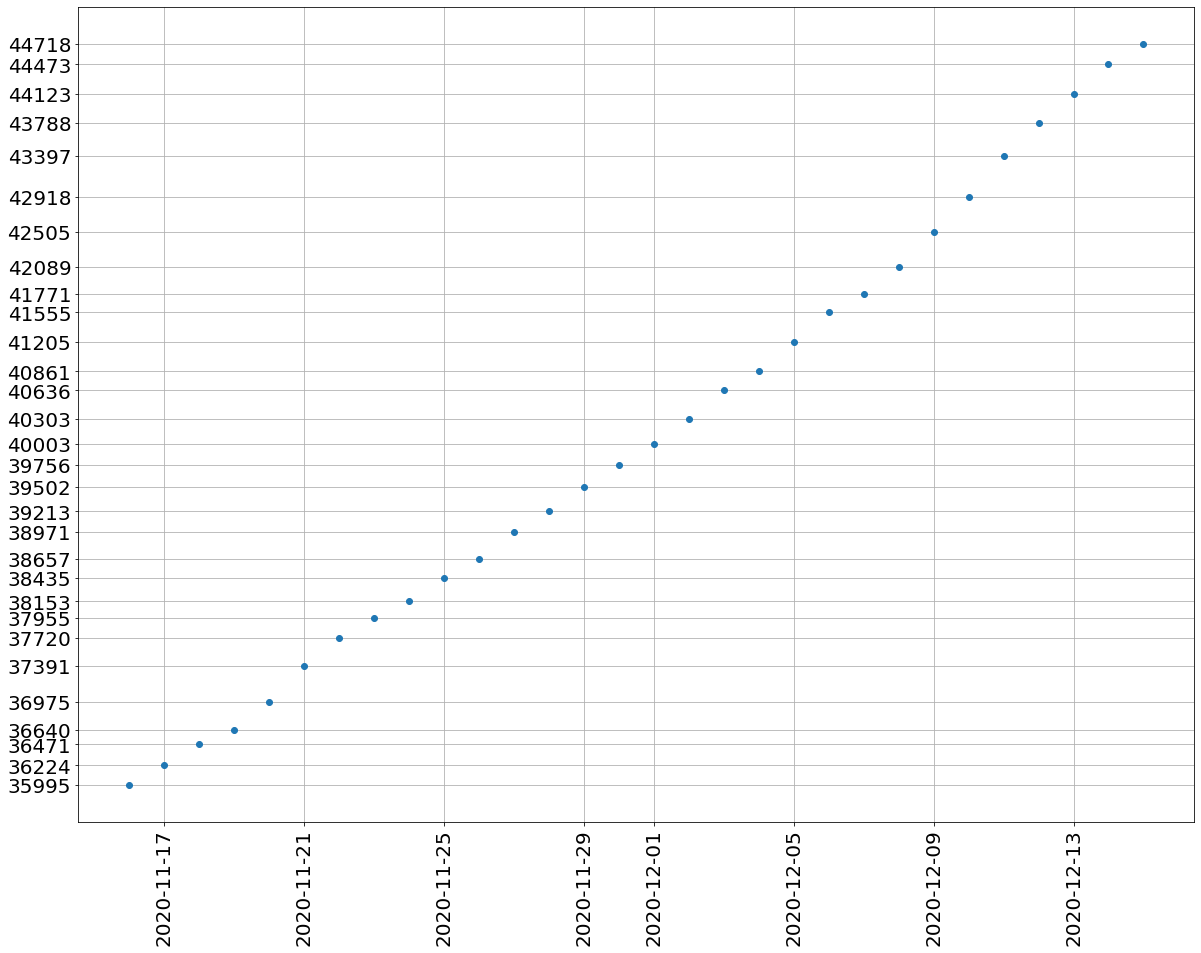

       Date_of_report  Total_reported
91125      2020-11-16           35995
91492      2020-11-17           36224
91859      2020-11-18           36471
92226      2020-11-19           36640
92593      2020-11-20           36975
92960      2020-11-21           37391
93327      2020-11-22           37720
93694      2020-11-23           37955
94061      2020-11-24           38153
94428      2020-11-25           38435
94795      2020-11-26           38657
95162      2020-11-27           38971
95529      2020-11-28           39213
95896      2020-11-29           39502
96263      2020-11-30           39756
96630      2020-12-01           40003
96997      2020-12-02           40303
97364      2020-12-03           40636
97731      2020-12-04           40861
98098      2020-12-05           41205
98465      2020-12-06           41555
98832      2020-12-07           41771
99199      2020-12-08           42089
99566      2020-12-09           42505
99933      2020-12-10           42918
100300     2

In [10]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Total_reported")

### Cumulative reported cases since beginning

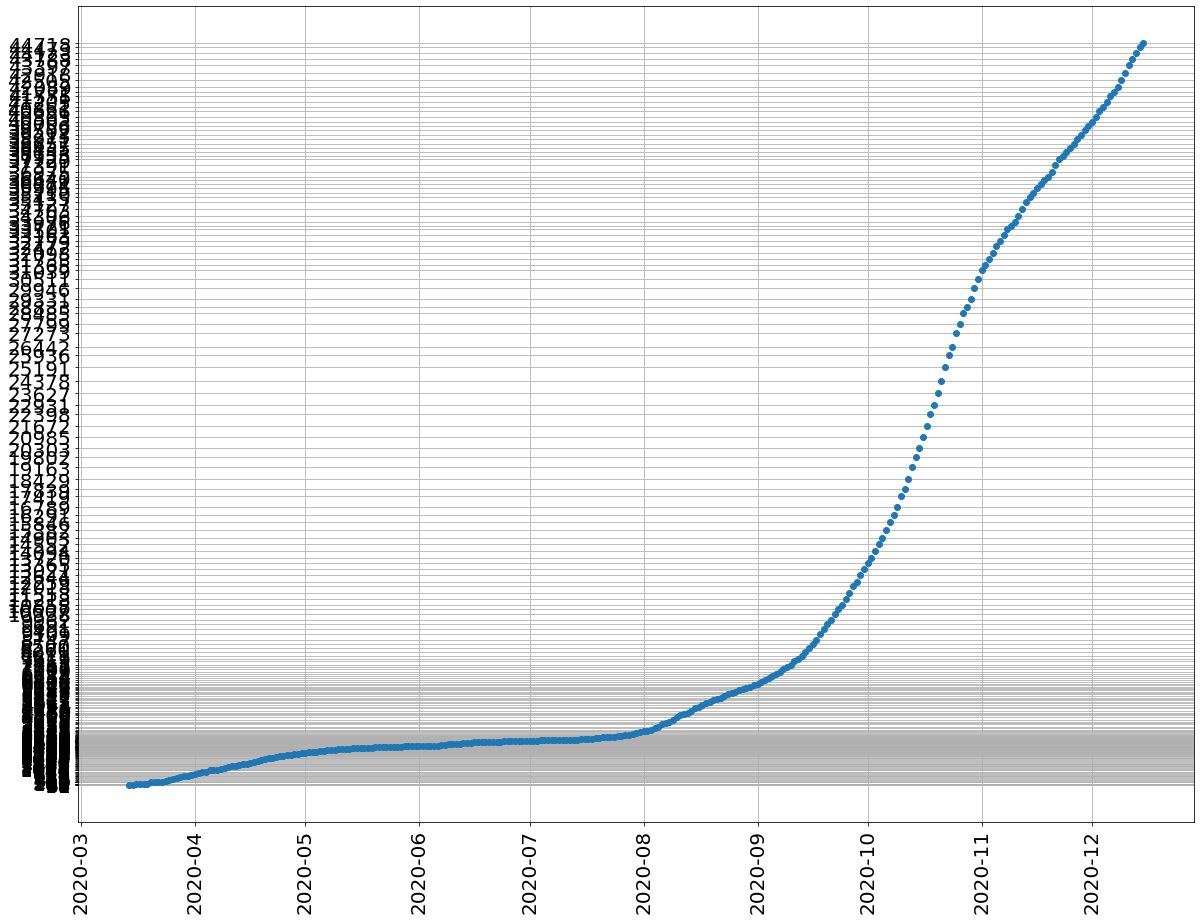

       Date_of_report  Total_reported
476        2020-03-14              31
843        2020-03-15              31
1210       2020-03-16              39
1577       2020-03-17              56
1944       2020-03-18              61
...               ...             ...
100300     2020-12-11           43397
100667     2020-12-12           43788
101034     2020-12-13           44123
101401     2020-12-14           44473
101768     2020-12-15           44718

[277 rows x 2 columns]


In [11]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Total_reported")

### Cumulative hospitalizations for last 30 days

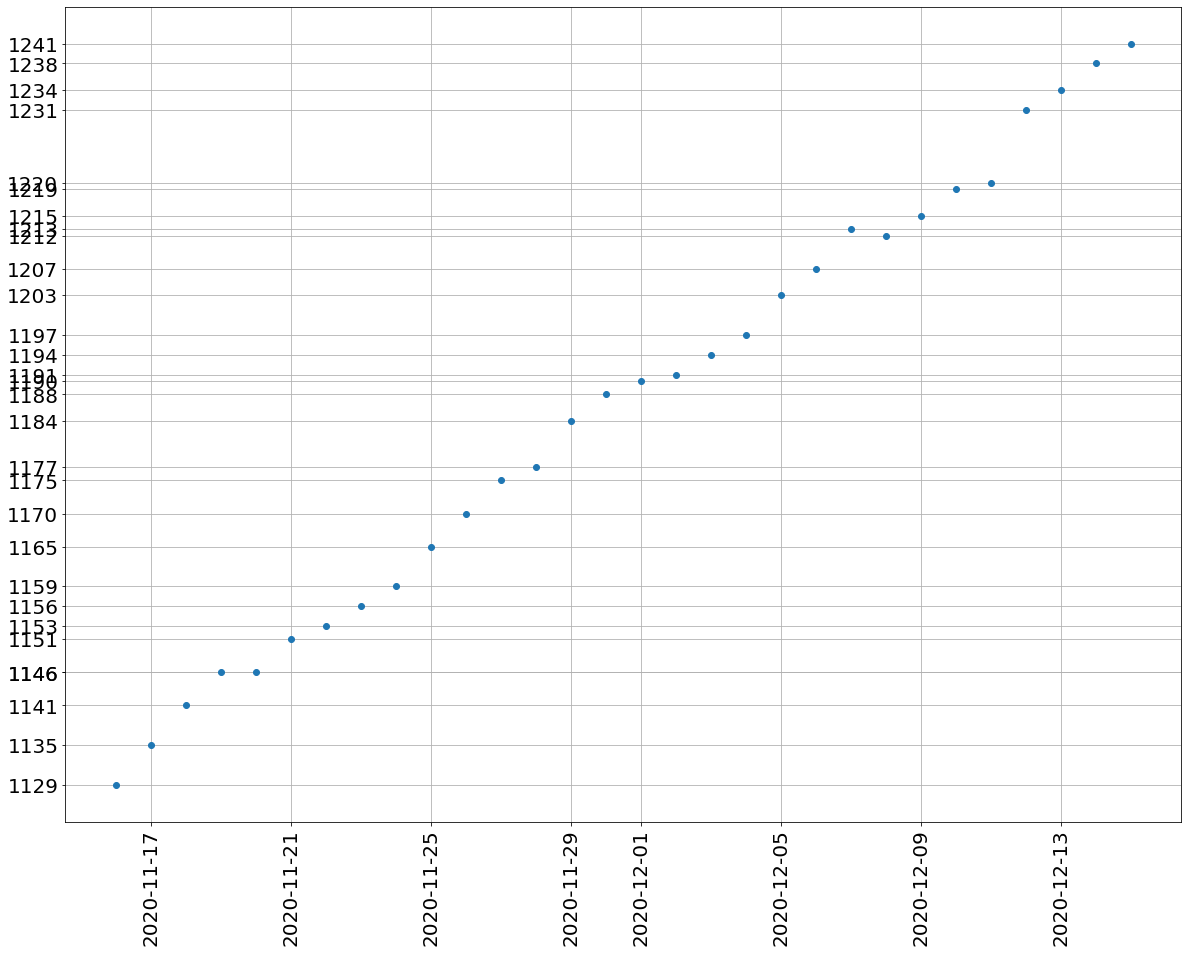

       Date_of_report  Hospital_admission
91125      2020-11-16                1129
91492      2020-11-17                1135
91859      2020-11-18                1141
92226      2020-11-19                1146
92593      2020-11-20                1146
92960      2020-11-21                1151
93327      2020-11-22                1153
93694      2020-11-23                1156
94061      2020-11-24                1159
94428      2020-11-25                1165
94795      2020-11-26                1170
95162      2020-11-27                1175
95529      2020-11-28                1177
95896      2020-11-29                1184
96263      2020-11-30                1188
96630      2020-12-01                1190
96997      2020-12-02                1191
97364      2020-12-03                1194
97731      2020-12-04                1197
98098      2020-12-05                1203
98465      2020-12-06                1207
98832      2020-12-07                1213
99199      2020-12-08             

In [12]:
plot_cumul_reported_last_n_days(cumuldf, 30, "Hospital_admission")

### Cumulative hospitalizations since beginning

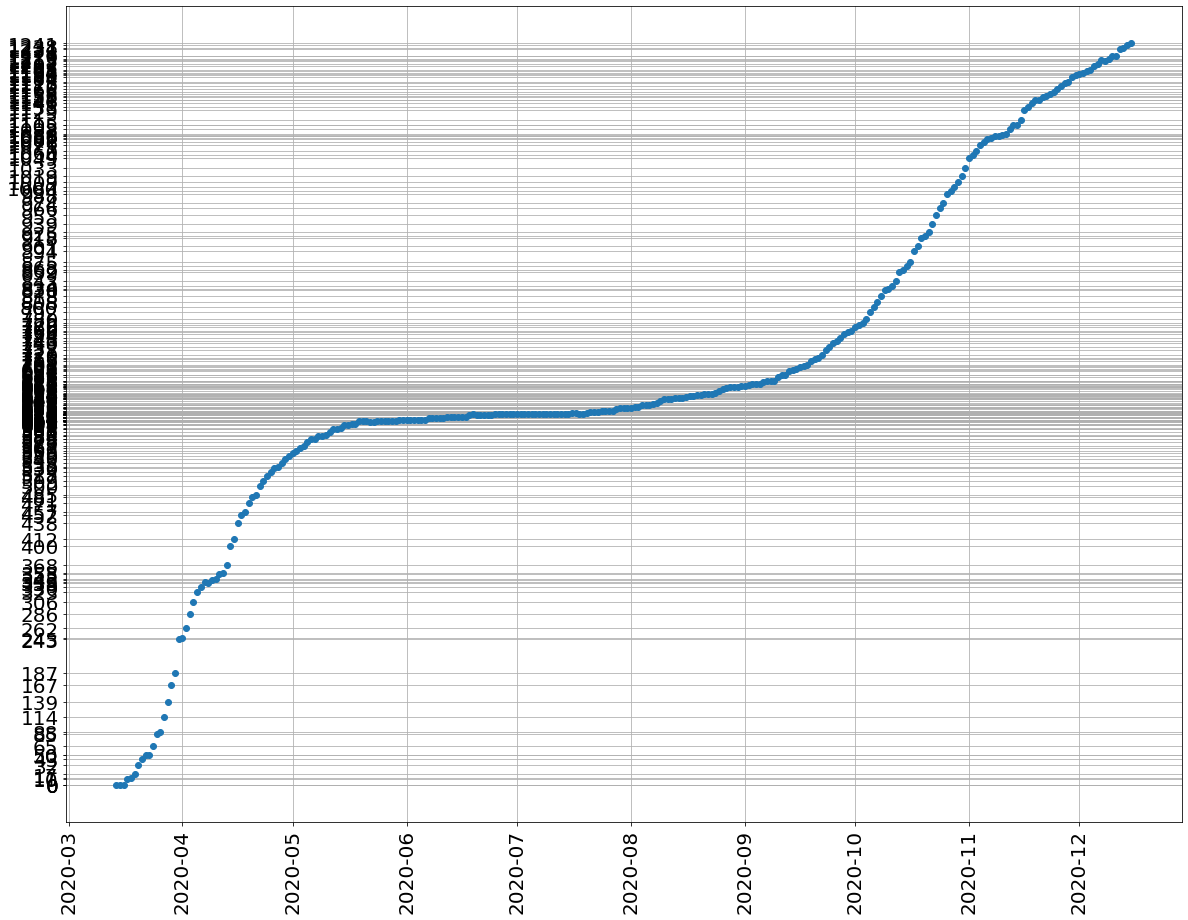

       Date_of_report  Hospital_admission
476        2020-03-14                   0
843        2020-03-15                   0
1210       2020-03-16                   0
1577       2020-03-17                  10
1944       2020-03-18                  11
...               ...                 ...
100300     2020-12-11                1220
100667     2020-12-12                1231
101034     2020-12-13                1234
101401     2020-12-14                1238
101768     2020-12-15                1241

[277 rows x 2 columns]


In [13]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Hospital_admission")

### Cumulative deaths since beginning

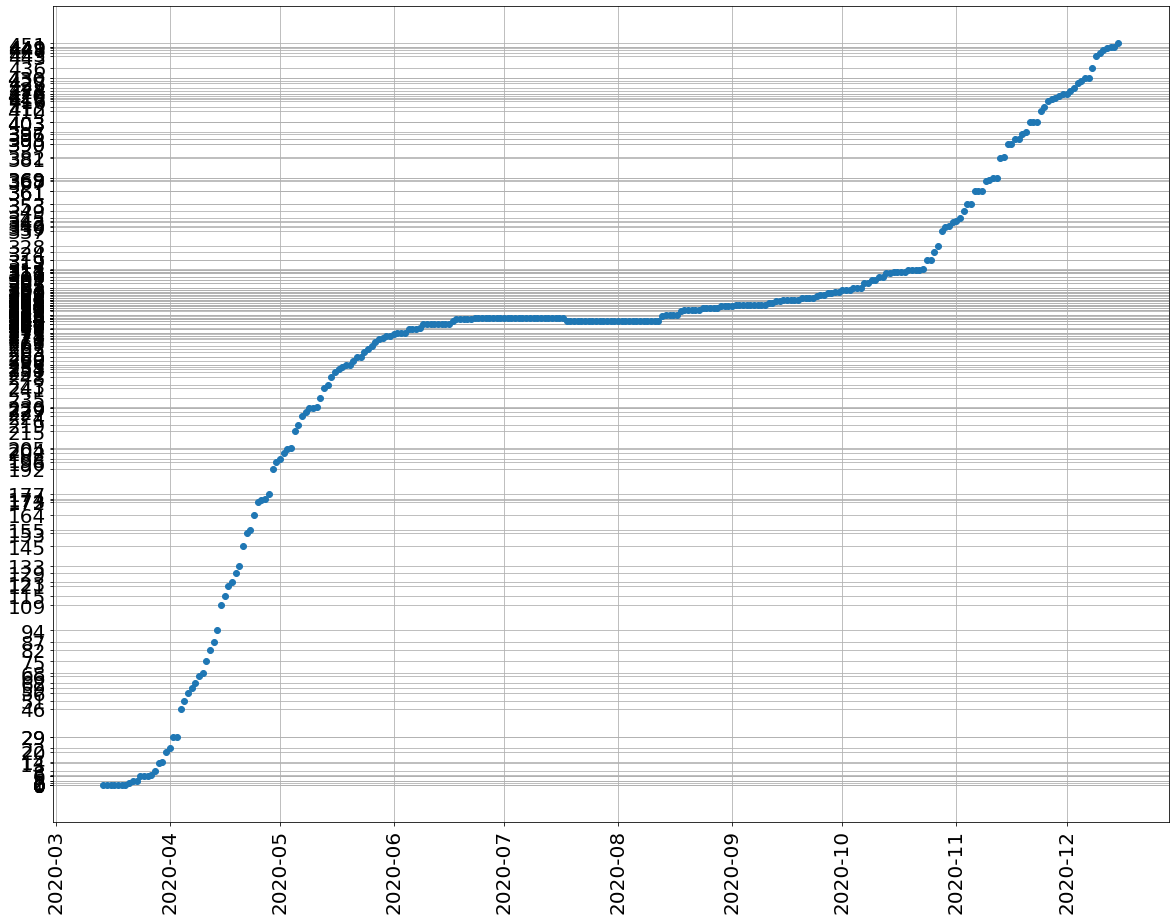

       Date_of_report  Deceased
476        2020-03-14         0
843        2020-03-15         0
1210       2020-03-16         0
1577       2020-03-17         0
1944       2020-03-18         0
...               ...       ...
100300     2020-12-11       447
100667     2020-12-12       448
101034     2020-12-13       449
101401     2020-12-14       449
101768     2020-12-15       451

[277 rows x 2 columns]


In [14]:
plot_cumul_reported_last_n_days(cumuldf, -1, "Deceased")